<a href="https://colab.research.google.com/github/tanjinadnanabir/Neuromatch-Academy/blob/main/NLP_Sentiment_Analysis_Project_Perun_G1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# --- Load and Explore Data ---
try:
    column = ['sentence','sentiment']
    df = pd.read_csv('/content/sentences_sentiment.csv', names=column)
    print("Dataset loaded successfully...")
    print(df.head())
    df.info()
    print(df['sentiment'].value_counts())
except FileNotFoundError:
    print("Error: 'sentences_sentiment.csv' not found...")
    exit()

TEXT_COLUMN = 'sentence'
LABEL_COLUMN = 'sentiment'

unique_sentiments = df[LABEL_COLUMN].unique()

sentiment_to_int = {label: i for i, label in enumerate(sorted(unique_sentiments))}
int_to_sentiment = {i: label for i, label in enumerate(sorted(unique_sentiments))}

df[LABEL_COLUMN] = df[LABEL_COLUMN].map(sentiment_to_int)
print(f"\nSentiment to integer mapping: {sentiment_to_int}")
print(f"Integer to sentiment mapping: {int_to_sentiment}")
print(df.head())

Dataset loaded successfully...
                                            sentence sentiment
0  The Rock is destined to be the 21st Century 's...  POSITIVE
1  The gorgeously elaborate continuation of `` Th...  POSITIVE
2  Singer\/composer Bryan Adams contributes a sle...  POSITIVE
3  You 'd think by now America would have had eno...   NEUTRAL
4               Yet the act is still charming here .  POSITIVE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11853 entries, 0 to 11852
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11853 non-null  object
 1   sentiment  11853 non-null  object
dtypes: object(2)
memory usage: 185.3+ KB
sentiment
POSITIVE    4963
NEGATIVE    4649
NEUTRAL     2241
Name: count, dtype: int64

Sentiment to integer mapping: {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
Integer to sentiment mapping: {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
                                            sen

In [ ]:
# --- Preprocessing ---

def preprocess_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # URLs
    text = re.sub(r'@\w+', '', text) # mentions
    text = re.sub(r'#\w+', '', text) # hashtags
    text = re.sub(r'[^a-z\s]', '', text) # punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip() # extra whitespaces
    return text

df[TEXT_COLUMN] = df[TEXT_COLUMN].apply(preprocess_text)
print(df.head())

# Tokenization and Vocabulary Building

all_words = []
for text in df[TEXT_COLUMN]:
    all_words.extend(text.split())

word_counts = Counter(all_words)
# Sort words by freq and alphabetic for order
sorted_vocab = sorted(word_counts.items(), key=lambda x: (-x[1], x[0]))
vocab_to_int = {word: i + 2 for i, (word, count) in enumerate(sorted_vocab)}

vocab_to_int['<PAD>'] = 0 # Padding token
vocab_to_int['<UNK>'] = 1 # Unknown word token

int_to_vocab = {i: word for word, i in vocab_to_int.items()}

print(f"\nVocab size: {len(vocab_to_int)}")
print(list(vocab_to_int.items())[:10])

# text to num seq convertion
def text_to_sequence(text, vocab_to_int):
    return [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in text.split()]

df['encoded_text'] = df[TEXT_COLUMN].apply(lambda x: text_to_sequence(x, vocab_to_int))
print(df.head())

# Max seq length for padding
max_seq_len = max([len(seq) for seq in df['encoded_text']])
print(f"\nMax sequence length: {max_seq_len}")

# Padding sequences
def pad_sequence(sequence, max_len, pad_token):
    if len(sequence) < max_len:
        return sequence + [pad_token] * (max_len - len(sequence))
    return sequence[:max_len] # Truncate if longer

df['padded_encoded_text'] = df['encoded_text'].apply(lambda x: pad_sequence(x, max_seq_len, vocab_to_int['<PAD>']))
print(df.head())

                                            sentence  sentiment  \
0  the rock is destined to be the st century s ne...          2   
1  the gorgeously elaborate continuation of the l...          2   
2  singercomposer bryan adams contributes a slew ...          2   
3  you d think by now america would have had enou...          1   
4                 yet the act is still charming here          2   

                                        encoded_text  \
0  [2, 607, 8, 2580, 6, 23, 2, 2471, 1160, 7, 99,...   
1  [2, 3420, 2117, 7536, 5, 2, 4145, 5, 2, 3112, ...   
2  [17181, 7347, 2265, 11525, 3, 17279, 5, 1384, ...   
3  [21, 275, 239, 26, 326, 713, 85, 37, 204, 76, ...   
4                    [173, 2, 593, 8, 117, 352, 139]   

                                 padded_encoded_text  
0  [2, 607, 8, 2580, 6, 23, 2, 2471, 1160, 7, 99,...  
1  [2, 3420, 2117, 7536, 5, 2, 4145, 5, 2, 3112, ...  
2  [17181, 7347, 2265, 11525, 3, 17279, 5, 1384, ...  
3  [21, 275, 239, 26, 326, 713, 85, 37, 

In [ ]:
# --- Dataset and DataLoader ---

class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels) # len of total num of samples

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    df['padded_encoded_text'].tolist(),
    df[LABEL_COLUMN].tolist(),
    test_size=0.2, # 20% for test
    random_state=42,
    stratify=df[LABEL_COLUMN].tolist() # for maintaining balance class distribution
)

train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train:", len(train_dataset))
print("Test:",len(test_dataset))
print(len(train_loader))
print(len(test_loader))

# Example batch from DataLoader
# for texts, labels in train_loader:
#     print("\nExample batch from DataLoader:")
#     print("Texts batch shape:", texts.shape)
#     print("Labels batch shape:", labels.shape)
#     print("First text in batch (padded sequence):", texts[0])
#     print("Corresponding label:", labels[0])
#     break

Train: 9482
Test: 2371
149
38


In [ ]:
# --- PyTorch Models (RNN, GRU, LSTM, BiLSTM) Defination ---

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        hidden_last_layer = hidden[-1,:,:]
        return self.fc(hidden_last_layer)

class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        hidden_last_layer = hidden[-1,:,:]
        return self.fc(hidden_last_layer)

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden_last_layer = hidden[-1,:,:]
        return self.fc(hidden_last_layer)

class SentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # bidirectional=True means hidden_dim will be multiplied by 2 in the output
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout,
                            batch_first=True, bidirectional=True)
        # Output from bidirectional LSTM will be hidden_dim * 2
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final forward and backward hidden states
        hidden_forward = hidden[-2, :, :] # Second to last layer for forward
        hidden_backward = hidden[-1, :, :] # Last layer for backward
        hidden_combined = torch.cat((hidden_forward, hidden_backward), dim=1)
        # hidden_combined = [batch size, hidden dim * 2]

        return self.fc(hidden_combined)

In [ ]:
# --- Training and Evaluation Functions ---

def train_model(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train() # Set model to training mode

    for texts, labels in iterator:
        texts = texts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # Clear gradients
        predictions = model(texts).squeeze(1)

        if model.fc.out_features == 1:
            labels = labels.float()

        loss = criterion(predictions, labels)
        # For multi-class, using argmax
        if model.fc.out_features > 1:
            acc = (predictions.argmax(dim=1) == labels).float().mean()
        else: # Binary classification
            # Apply sigmoid and round for accuracy calculation
            rounded_predictions = torch.round(torch.sigmoid(predictions))
            acc = (rounded_predictions == labels).float().mean()

        loss.backward() # Backpropagate
        optimizer.step() # Update weights

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_model(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            labels = labels.to(device)

            predictions = model(texts).squeeze(1)

            if model.fc.out_features == 1:
                labels = labels.float()

            loss = criterion(predictions, labels)

            if model.fc.out_features > 1:
                acc = (predictions.argmax(dim=1) == labels).float().mean()
            else:
                rounded_predictions = torch.round(torch.sigmoid(predictions))
                acc = (rounded_predictions == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# --- Model Initiate, Training, and Testing ---

# Hyperparameters
VOCAB_SIZE = len(vocab_to_int)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(unique_sentiments)
N_LAYERS = 2
DROPOUT = 0.5
N_EPOCHS = 10
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = {}

In [ ]:
# --- Train and Evaluate RNN ---
print("\n--- Training RNN Model ---")
model_rnn = SentimentRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)
# CrossEntropyLoss for multi-class classification
criterion_rnn = nn.CrossEntropyLoss() if OUTPUT_DIM > 1 else nn.BCEWithLogitsLoss()

best_valid_loss_rnn = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_model(model_rnn, train_loader, optimizer_rnn, criterion_rnn, device)
    valid_loss, valid_acc = evaluate_model(model_rnn, test_loader, criterion_rnn, device)

    if valid_loss < best_valid_loss_rnn:
        best_valid_loss_rnn = valid_loss
        torch.save(model_rnn.state_dict(), 'rnn_model.pt')

    print(f'RNN Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

# Load model and evaluate on test set
model_rnn.load_state_dict(torch.load('rnn_model.pt'))
test_loss_rnn, test_acc_rnn = evaluate_model(model_rnn, test_loader, criterion_rnn, device)
print(f'RNN Test Loss: {test_loss_rnn:.3f} | RNN Test Acc: {test_acc_rnn*100:.2f}%')
results['RNN'] = {'Test Loss': test_loss_rnn, 'Test Accuracy': test_acc_rnn}



Step 6: Instantiating, Training, and Testing Models...
Using device: cpu

--- Training RNN Model ---
RNN Epoch: 01 | Train Loss: 1.076 | Train Acc: 40.19% | Valid Loss: 1.055 | Valid Acc: 42.50%
RNN Epoch: 02 | Train Loss: 1.055 | Train Acc: 41.80% | Valid Loss: 1.049 | Valid Acc: 42.50%
RNN Epoch: 03 | Train Loss: 1.056 | Train Acc: 40.12% | Valid Loss: 1.050 | Valid Acc: 42.50%
RNN Epoch: 04 | Train Loss: 1.053 | Train Acc: 40.85% | Valid Loss: 1.052 | Valid Acc: 42.50%
RNN Epoch: 05 | Train Loss: 1.053 | Train Acc: 40.01% | Valid Loss: 1.058 | Valid Acc: 42.50%
RNN Epoch: 06 | Train Loss: 1.058 | Train Acc: 39.78% | Valid Loss: 1.087 | Valid Acc: 38.24%
RNN Epoch: 07 | Train Loss: 1.052 | Train Acc: 41.07% | Valid Loss: 1.058 | Valid Acc: 38.24%
RNN Epoch: 08 | Train Loss: 1.055 | Train Acc: 41.00% | Valid Loss: 1.052 | Valid Acc: 38.24%
RNN Epoch: 09 | Train Loss: 1.052 | Train Acc: 41.17% | Valid Loss: 1.068 | Valid Acc: 42.50%
RNN Epoch: 10 | Train Loss: 1.055 | Train Acc: 40.60

In [ ]:
# --- Train and Evaluate GRU ---
print("\n--- Training GRU Model ---")
model_gru = SentimentGRU(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)
criterion_gru = nn.CrossEntropyLoss() if OUTPUT_DIM > 1 else nn.BCEWithLogitsLoss()

best_valid_loss_gru = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_model(model_gru, train_loader, optimizer_gru, criterion_gru, device)
    valid_loss, valid_acc = evaluate_model(model_gru, test_loader, criterion_gru, device)

    if valid_loss < best_valid_loss_gru:
        best_valid_loss_gru = valid_loss
        torch.save(model_gru.state_dict(), 'gru_model.pt')

    print(f'GRU Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

model_gru.load_state_dict(torch.load('gru_model.pt'))
test_loss_gru, test_acc_gru = evaluate_model(model_gru, test_loader, criterion_gru, device)
print(f'GRU Test Loss: {test_loss_gru:.3f} | GRU Test Acc: {test_acc_gru*100:.2f}%')
results['GRU'] = {'Test Loss': test_loss_gru, 'Test Accuracy': test_acc_gru}


# --- Train and Evaluate LSTM ---
print("\n--- Training LSTM Model ---")
model_lstm = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
criterion_lstm = nn.CrossEntropyLoss() if OUTPUT_DIM > 1 else nn.BCEWithLogitsLoss()

best_valid_loss_lstm = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_model(model_lstm, train_loader, optimizer_lstm, criterion_lstm, device)
    valid_loss, valid_acc = evaluate_model(model_lstm, test_loader, criterion_lstm, device)

    if valid_loss < best_valid_loss_lstm:
        best_valid_loss_lstm = valid_loss
        torch.save(model_lstm.state_dict(), 'lstm_model.pt')

    print(f'LSTM Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

model_lstm.load_state_dict(torch.load('lstm_model.pt'))
test_loss_lstm, test_acc_lstm = evaluate_model(model_lstm, test_loader, criterion_lstm, device)
print(f'LSTM Test Loss: {test_loss_lstm:.3f} | LSTM Test Acc: {test_acc_lstm*100:.2f}%')
results['LSTM'] = {'Test Loss': test_loss_lstm, 'Test Accuracy': test_acc_lstm}


# --- Train and Evaluate BiLSTM ---
print("\n--- Training BiLSTM Model ---")
model_bilstm = SentimentBiLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)
optimizer_bilstm = optim.Adam(model_bilstm.parameters(), lr=LEARNING_RATE)
criterion_bilstm = nn.CrossEntropyLoss() if OUTPUT_DIM > 1 else nn.BCEWithLogitsLoss()

best_valid_loss_bilstm = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_model(model_bilstm, train_loader, optimizer_bilstm, criterion_bilstm, device)
    valid_loss, valid_acc = evaluate_model(model_bilstm, test_loader, criterion_bilstm, device)

    if valid_loss < best_valid_loss_bilstm:
        best_valid_loss_bilstm = valid_loss
        torch.save(model_bilstm.state_dict(), 'bilstm_model.pt')

    print(f'BiLSTM Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

model_bilstm.load_state_dict(torch.load('bilstm_model.pt'))
test_loss_bilstm, test_acc_bilstm = evaluate_model(model_bilstm, test_loader, criterion_bilstm, device)
print(f'BiLSTM Test Loss: {test_loss_bilstm:.3f} | BiLSTM Test Acc: {test_acc_bilstm*100:.2f}%')
results['BiLSTM'] = {'Test Loss': test_loss_bilstm, 'Test Accuracy': test_acc_bilstm}

print("\n--- All Models Training and Testing Complete ---")
print("\nSummary of Test Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Test Loss: {metrics['Test Loss']:.3f}")
    print(f"  Test Accuracy: {metrics['Test Accuracy']*100:.2f}%")



--- Training GRU Model ---
GRU Epoch: 01 | Train Loss: 1.056 | Train Acc: 40.85% | Valid Loss: 1.058 | Valid Acc: 38.24%
GRU Epoch: 02 | Train Loss: 1.054 | Train Acc: 41.07% | Valid Loss: 1.057 | Valid Acc: 42.50%
GRU Epoch: 03 | Train Loss: 1.052 | Train Acc: 40.38% | Valid Loss: 1.049 | Valid Acc: 42.50%
GRU Epoch: 04 | Train Loss: 1.049 | Train Acc: 41.87% | Valid Loss: 1.054 | Valid Acc: 38.24%
GRU Epoch: 05 | Train Loss: 1.048 | Train Acc: 41.95% | Valid Loss: 1.039 | Valid Acc: 46.07%
GRU Epoch: 06 | Train Loss: 1.027 | Train Acc: 47.80% | Valid Loss: 0.990 | Valid Acc: 52.78%
GRU Epoch: 07 | Train Loss: 0.981 | Train Acc: 53.91% | Valid Loss: 0.952 | Valid Acc: 57.68%
GRU Epoch: 08 | Train Loss: 0.921 | Train Acc: 58.60% | Valid Loss: 0.910 | Valid Acc: 60.18%
GRU Epoch: 09 | Train Loss: 0.868 | Train Acc: 62.08% | Valid Loss: 0.893 | Valid Acc: 60.59%
GRU Epoch: 10 | Train Loss: 0.831 | Train Acc: 63.95% | Valid Loss: 0.901 | Valid Acc: 61.75%
GRU Test Loss: 0.893 | GRU Test 

In [ ]:
# --- Prediction Function ---

def predict_sentiment(model, sentence, vocab_to_int, max_seq_len, pad_token, device, int_to_sentiment):
    model.eval()
    preprocessed_sentence = preprocess_text(sentence)
    encoded_sentence = text_to_sequence(preprocessed_sentence, vocab_to_int)
    padded_sentence = pad_sequence(encoded_sentence, max_seq_len, pad_token)

    # Converting to tensor and add batch dimension
    tensor_sentence = torch.tensor(padded_sentence, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(tensor_sentence)

        if model.fc.out_features == 1: # Binary classification
            probability = torch.sigmoid(prediction).item()
            predicted_class = 1 if probability >= 0.5 else 0
            sentiment = int_to_sentiment[predicted_class]
            return sentiment, probability
        else: # Multi-class classification
            probabilities = torch.softmax(prediction, dim=1)
            predicted_class = probabilities.argmax(dim=1).item()
            sentiment = int_to_sentiment[predicted_class]
            return sentiment, probabilities[0][predicted_class].item()

print("\n--- Example Sentiment Prediction ---")
# Loading the best model for prediction
# model_bilstm.load_state_dict(torch.load('bilstm_model.pt'))
model_gru.load_state_dict(torch.load('gru_model.pt'))

test_sentences = [
    "The service was terrible and the food was cold.",
    "It's an okay product, nothing special.",
    "I am so happy with this purchase.",
    "What a waste of time and money."
]

for sentence in test_sentences:
    predicted_sentiment, confidence = predict_sentiment(
        model_bilstm, sentence, vocab_to_int, max_seq_len, vocab_to_int['<PAD>'], device, int_to_sentiment
    )
    print(f"Sentence: '{sentence}'")
    print(f"Predicted Sentiment: {predicted_sentiment} (Confidence: {confidence:.4f})\n")


--- Example Sentiment Prediction ---
Sentence: 'The service was terrible and the food was cold.'
Predicted Sentiment: NEGATIVE (Confidence: 0.8301)

Sentence: 'It's an okay product, nothing special.'
Predicted Sentiment: NEGATIVE (Confidence: 0.7967)

Sentence: 'I am so happy with this purchase.'
Predicted Sentiment: POSITIVE (Confidence: 0.4963)

Sentence: 'What a waste of time and money.'
Predicted Sentiment: NEGATIVE (Confidence: 0.8378)



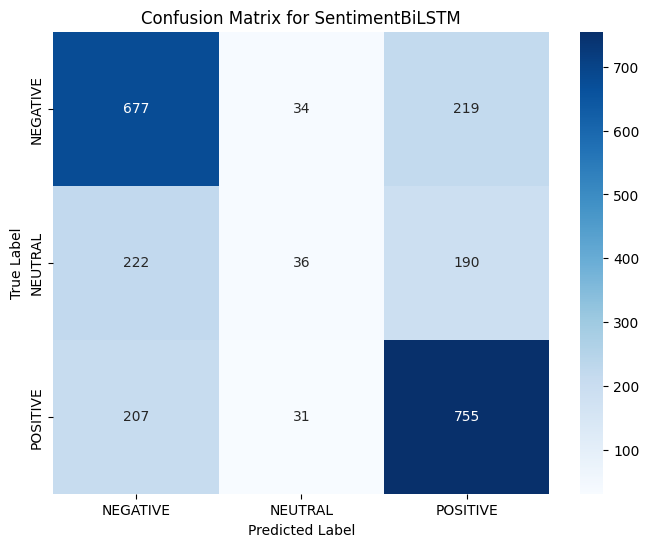

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def get_predictions(model, iterator, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            labels = labels.to(device)

            predictions = model(texts).squeeze(1)

            if model.fc.out_features > 1: # Multi-class
                predicted_classes = predictions.argmax(dim=1)
            else: # Binary
                predicted_classes = torch.round(torch.sigmoid(predictions))

            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_predictions)

model_to_evaluate = model_bilstm # Choosing the model from four

true_labels, predicted_labels = get_predictions(model_to_evaluate, test_loader, device)

# Computing confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(unique_sentiments),
            yticklabels=sorted(unique_sentiments))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {model_to_evaluate.__class__.__name__}')
plt.show()

# Display normalized confusion matrix
# cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
#             xticklabels=sorted(unique_sentiments),
#             yticklabels=sorted(unique_sentiments))
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title(f'Normalized Confusion Matrix for {model_to_evaluate.__class__.__name__}')
# plt.show()

In [ ]:
# --- TextCNN Model ---
class SentimentTextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Define a convolutional layer for each filter size
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, seq len]
        embedded = self.embedding(text)
        # embedded = [batch size, seq len, embedding dim]

        # Add a channel dimension for Conv2d
        embedded = embedded.unsqueeze(1)
        # embedded = [batch size, 1, seq len, embedding dim]

        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n = [batch size, n_filters, (seq len - filter_size + 1)]

        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

In [ ]:
# Enhanced Hyperparameters
VOCAB_SIZE = len(vocab_to_int)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512 # Used for RNN/GRU/LSTM/BiLSTM
OUTPUT_DIM = len(unique_sentiments)
N_LAYERS = 2
DROPOUT = 0.5
N_EPOCHS = 30
LEARNING_RATE = 0.001
PATIENCE = 5

# TextCNN specific hyperparameters
N_FILTERS = 100 # Number of filters for each filter size
FILTER_SIZES = [2, 3, 4] # Filter sizes (n-grams to capture)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = {}

# --- Train and Evaluate TextCNN ---
print("\n--- Training TextCNN Model (New) ---")
model_cnn = SentimentTextCNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT).to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE)
criterion_cnn = nn.CrossEntropyLoss() if OUTPUT_DIM > 1 else nn.BCEWithLogitsLoss()

best_valid_loss_cnn = float('inf')
epochs_no_improve_cnn = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_model(model_cnn, train_loader, optimizer_cnn, criterion_cnn, device)
    valid_loss, valid_acc = evaluate_model(model_cnn, test_loader, criterion_cnn, device)

    if valid_loss < best_valid_loss_cnn:
        best_valid_loss_cnn = valid_loss
        torch.save(model_cnn.state_dict(), 'cnn_model_enhanced.pt')
        epochs_no_improve_cnn = 0
    else:
        epochs_no_improve_cnn += 1

    print(f'TextCNN Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

    if epochs_no_improve_cnn == PATIENCE:
        print(f'Early stopping triggered for TextCNN at epoch {epoch+1}.')
        break

model_cnn.load_state_dict(torch.load('cnn_model_enhanced.pt'))
test_loss_cnn, test_acc_cnn = evaluate_model(model_cnn, test_loader, criterion_cnn, device)
print(f'TextCNN Test Loss: {test_loss_cnn:.3f} | TextCNN Test Acc: {test_acc_cnn*100:.2f}%')
results['TextCNN (Enhanced)'] = {'Test Loss': test_loss_cnn, 'Test Accuracy': test_acc_cnn}


Using device: cpu

--- Training TextCNN Model (New) ---
TextCNN Epoch: 01 | Train Loss: 1.090 | Train Acc: 46.24% | Valid Loss: 0.975 | Valid Acc: 52.56%
TextCNN Epoch: 02 | Train Loss: 0.905 | Train Acc: 58.46% | Valid Loss: 0.952 | Valid Acc: 58.61%
TextCNN Epoch: 03 | Train Loss: 0.769 | Train Acc: 66.71% | Valid Loss: 0.919 | Valid Acc: 58.85%
TextCNN Epoch: 04 | Train Loss: 0.636 | Train Acc: 73.92% | Valid Loss: 0.901 | Valid Acc: 60.39%
TextCNN Epoch: 05 | Train Loss: 0.504 | Train Acc: 79.91% | Valid Loss: 0.965 | Valid Acc: 62.12%
TextCNN Epoch: 06 | Train Loss: 0.389 | Train Acc: 85.51% | Valid Loss: 1.036 | Valid Acc: 62.49%
TextCNN Epoch: 07 | Train Loss: 0.292 | Train Acc: 89.67% | Valid Loss: 1.054 | Valid Acc: 61.75%
TextCNN Epoch: 08 | Train Loss: 0.210 | Train Acc: 93.09% | Valid Loss: 1.148 | Valid Acc: 60.72%
TextCNN Epoch: 09 | Train Loss: 0.162 | Train Acc: 94.61% | Valid Loss: 1.252 | Valid Acc: 62.49%
Early stopping triggered for TextCNN at epoch 9.
TextCNN Test 

In [ ]:
# --- Prediction Function ---

def predict_sentiment(model, sentence, vocab_to_int, max_seq_len, pad_token, device, int_to_sentiment):
    model.eval()
    preprocessed_sentence = preprocess_text(sentence)
    encoded_sentence = text_to_sequence(preprocessed_sentence, vocab_to_int)
    padded_sentence = pad_sequence(encoded_sentence, max_seq_len, pad_token)

    # Converting to tensor and add batch dimension
    tensor_sentence = torch.tensor(padded_sentence, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(tensor_sentence)

        if model.fc.out_features == 1: # Binary classification
            probability = torch.sigmoid(prediction).item()
            predicted_class = 1 if probability >= 0.5 else 0
            sentiment = int_to_sentiment[predicted_class]
            return sentiment, probability
        else: # Multi-class classification
            probabilities = torch.softmax(prediction, dim=1)
            predicted_class = probabilities.argmax(dim=1).item()
            sentiment = int_to_sentiment[predicted_class]
            return sentiment, probabilities[0][predicted_class].item()

print("\n--- Example Sentiment Prediction ---")
# Loading the best model for prediction
# model_bilstm.load_state_dict(torch.load('bilstm_model.pt'))
model_cnn.load_state_dict(torch.load('cnn_model_enhanced.pt'))

test_sentences = [
    "The service was terrible and the food was cold.",
    "It's an okay product, nothing special.",
    "I am so happy with this purchase.",
    "What a waste of time and money."
]

for sentence in test_sentences:
    predicted_sentiment, confidence = predict_sentiment(
        model_bilstm, sentence, vocab_to_int, max_seq_len, vocab_to_int['<PAD>'], device, int_to_sentiment
    )
    print(f"Sentence: '{sentence}'")
    print(f"Predicted Sentiment: {predicted_sentiment} (Confidence: {confidence:.4f})\n")


--- Example Sentiment Prediction ---
Sentence: 'The movie was fantastic and the actors were amazing.'
Predicted Sentiment: NEGATIVE (Confidence: 0.7713)

Sentence: 'The service was terrible and the food was cold.'
Predicted Sentiment: NEGATIVE (Confidence: 0.8301)

Sentence: 'It's an okay product, nothing special.'
Predicted Sentiment: NEGATIVE (Confidence: 0.7967)

Sentence: 'I am so happy with this purchase.'
Predicted Sentiment: POSITIVE (Confidence: 0.4963)

Sentence: 'What a waste of time and money.'
Predicted Sentiment: NEGATIVE (Confidence: 0.8378)

